##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-03-23 20:28:35--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.3.16, 2607:f8b0:4026:800::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.3.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   351MB/s    in 0.2s    

2020-03-23 20:28:36 (351 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                 

In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-03-23 20:35:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.3.48, 2607:f8b0:4026:800::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.3.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   208MB/s    in 0.3s    

2020-03-23 20:35:48 (208 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
Epoch 1/20
100/100 - 28s - loss: 0.5222 - acc: 0.7440 - val_loss: 0.7559 - val_acc: 0.8260
Epoch 2/20
Epoch 1/20
100/100 - 18s - loss: 0.4005 - acc: 0.8175 - val_loss: 0.2944 - val_acc: 0.9250
Epoch 3/20
Epoch 1/20
100/100 - 18s - loss: 0.3805 - acc: 0.8335 - val_loss: 0.2443 - val_acc: 0.9480
Epoch 4/20
Epoch 1/20
100/100 - 18s - loss: 0.3350 - acc: 0.8540 - val_loss: 0.3384 - val_acc: 0.9350
Epoch 5/20
Epoch 1/20
100/100 - 18s - loss: 0.3147 - acc: 0.8635 - val_loss: 0.3645 - val_acc: 0.9380
Epoch 6/20
Epoch 1/20
100/100 - 18s - loss: 0.3036 - acc: 0.8740 - val_loss: 0.4664 - val_acc: 0.9290
Epoch 7/20
Epoch 1/20
100/100 - 18s - loss: 0.3212 - acc: 0.8655 - val_loss: 0.3437 - val_acc: 0.9410
Epoch 8/20
Epoch 1/20
100/100 - 18s - loss: 0.2900 - acc: 0.8810 - val_loss: 0.3214 - val_acc: 0.9520
Epoch 9/20
Epoch 1/20
100/100 - 18s - loss: 0.2805 - acc: 0.8825 - val_loss: 0.4103 - val_acc: 0.9430
Epoch 10/20
Epoch 1/20
100/100 - 18s - loss: 0.2963 - acc: 0.8810 - val_loss: 0.62

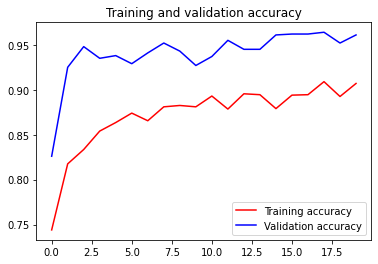

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()